In [1]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_data.grid_manager import pluck_point_new

plt.style.use('seaborn-notebook')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/h5py-2.7.0rc2-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/'
latlon_file = h5py.File(DIR+'HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

-----

# Percentile thresholds for given month and hour
Answers the question: At what percentile does the wind first exceed a threshold?  
- Darker colors = the wind threshold is more rare, becuase it is requires a 90th or 95th percentile to get that strong.  
- Lighter colors = the wind threshold is more common, becuase it only happens more than 10


In [4]:
def get_area(FILE, STAT):
    """
    Return the values from an area in the HDF5 file array
    """
    with h5py.File(FILE, 'r') as f:
        return f[STAT][:]

In [5]:
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
m = draw_CONUS_HRRR_map()

M = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Wind Speed Percentiles

In [10]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 10
hour = 18

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 5

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for P in percentiles:
    # Temporaritlye store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

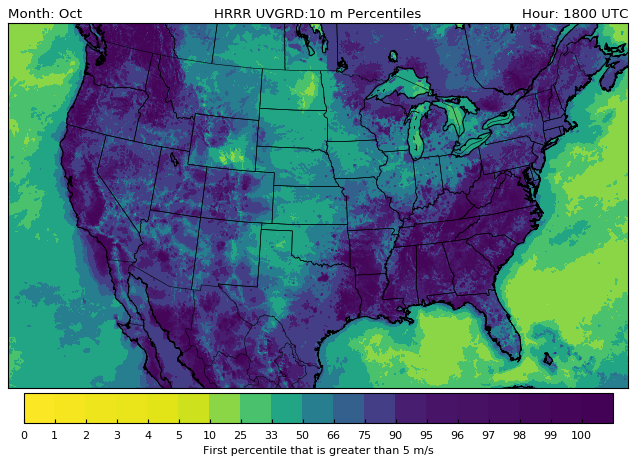

In [11]:
# Draw the Map
m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='viridis_r')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label('First percentile that is greater than %s m/s' % threshold)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/CONUS_percentiles_thresh_m%02d_h%02d' % (month, hour))

# Freezing Temperature Percentiles

In [9]:
# Percentile Variable and Statistic of interest
var = 'TMP:2 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 3
hour = 0

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 0

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
#percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*0

for P in percentiles:
    # Temporarily store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    if var == 'TMP:2 m':
        ptemp = ptemp-273.15
    pdata[ptemp <= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

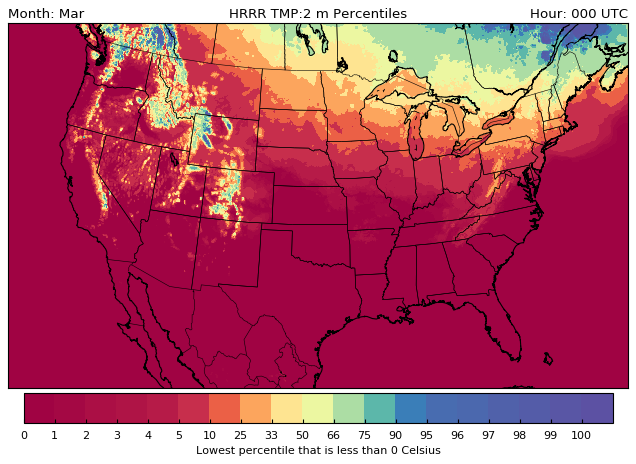

In [10]:
# Draw the Map
m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='Spectral')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label('Lowest percentile that is less than %s Celsius' % threshold)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/CONUS_percentiles_thresh_lowtemp_m%02d_h%02d' % (month, hour))

# 95 F (35 C) Temperature Percentiles

In [76]:
# Percentile Variable and Statistic of interest
var = 'TMP:2 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 8
hour = 22

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 35

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for P in percentiles:
    # Temporarily store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    if var == 'TMP:2 m':
        ptemp = ptemp-273.15
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

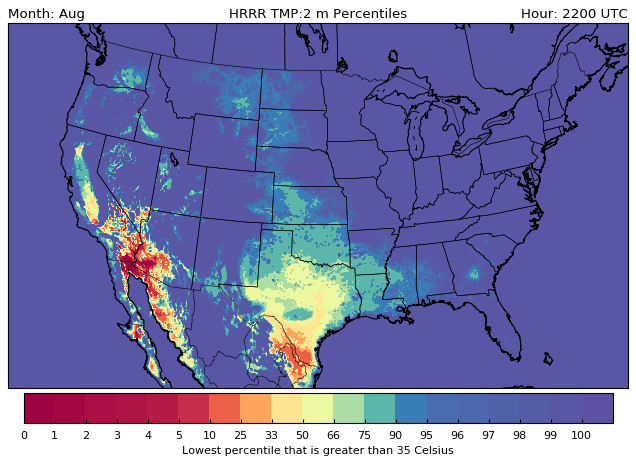

In [77]:
# Draw the Map
m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='Spectral')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label('Lowest percentile that is greater than %s Celsius' % threshold)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/CONUS_percentiles_thresh_hitemp_m%02d_h%02d' % (month, hour))

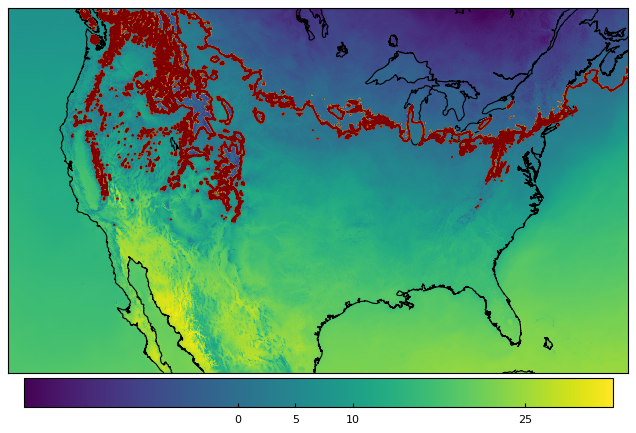

In [34]:
test = 25
test = get_area(FILE, 'p%02d' % test)
if var == 'TMP:2 m':
    test = test-273.15
threshold = 0

m.drawcoastlines()

m.pcolormesh(lon, lat, test,
             latlon=True,
             cmap='viridis')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=[0,5,10,25,33,50,66,75,90,95,100])

m.contour(lon, lat, test>threshold,
          latlon=True)

# Reflectivity

In [56]:
# Percentile Variable and Statistic of interest
var = 'REFC:entire'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 8
hour = 18

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 10

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for P in percentiles:
    # Temporaritlye store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

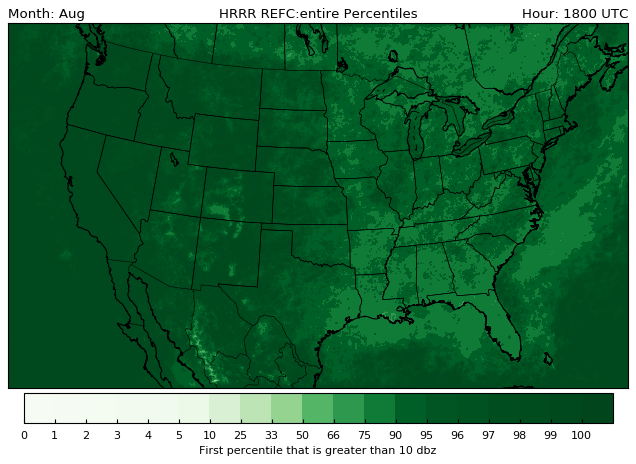

In [57]:
# Draw the Map
m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='Greens')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label('First percentile that is greater than %s dbz' % threshold)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/CONUS_percentiles_thresh_m%02d_h%02d_%s' % (month, hour, variable))